# Initial Data Exploration - Snohomish River at Monroe

In [2]:
# USGS site 12150800

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
# set up plotting
plt.style.use('default')
sns.set_palette('husl')

Initial data exploration for flood warning frequency analysis. Focus location is Snohomish River at Monroe, WA.

In [4]:
# USGS data collection via API. reference: https://api.waterdata.usgs.gov/

def get_usgs_data(site_id, parameter_code, start_date, end_date):
    """
    Download USGS data using their REST API. 

    params:
        site_id (str):           USGS site ID
        parameter_code (str):    parameter code (e.g., '00065' for stage, '00060' for discharge)
        start_date (str):        start date in 'YYYY-MM-DD' format
        end_date (str):          end date in 'YYYY-MM-DD' format

    output:
        df (DataFrame):          pandas DataFrame with time series data
        param_name (str):        name of the parameter
        param_unit (str):        unit of the parameter
    """

    base_url = "https://waterservices.usgs.gov/nwis/dv/"

    params = {
        'format': 'json',
        'sites': site_id,
        'parameterCd': parameter_code,
        'startDT': start_date,
        'endDT': end_date,
        'siteStatus': 'all'
    }

    print(f"Requesting data for parameter {parameter_code} from {start_date} to {end_date}")

    try:
        response = requests.get(base_url, params = params)
        response.raise_for_status() # raise an error for bad responses
        data = response.json() 

        # extract time series data
        # if 'value' in data and 'timeSeries' in data['value']:
        if 'value' in data and 'timeSeries' in data['value'] and len(data['value']['timeSeries']) > 0:
            if len(data['value']['timeSeries']) > 0:
                time_series = data['value']['timeSeries'][0]['values'][0]['value']

                # convert to dataframe
                df = pd.DataFrame(time_series)
                df['dateTime'] = pd.to_datetime(df['dateTime'])
                df['value'] = pd.to_numeric(df['value'], errors = 'coerce')
                df.set_index('dateTime', inplace = True)

                # get param info for labeling
                param_info = data['value']['timeSeries'][0]['variable']
                param_name = param_info['variableName']
                param_unit = param_info['unit']['unitCode']

                # debugging statements
                print(f"Successfully downloaded {len(df)} records of {param_name}")
                print(f"Units: {param_unit}")

                return df, param_name, param_unit
            else:
                print("No time series data found for the specified parameters.")
                return None, None, None
        else:
            print("No data found for the specified parameters.")
            return None, None, None

    except requests.exceptions.RequestException as e: # debug to figure out what's wrong
        print(f"Error fetching data: {e}")
        return None, None, None

### Specific Site Data Gathering (will change later)

In [5]:
# define our site and date range
site_id = '06902000'   # Snohomish river at Monroe -- 12150800
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365*5)).strftime('%Y-%m-%d')  # Last 5 years

print(f"\nCollecting data from {start_date} to {end_date}")

# download stage data
stage_data, stage_name, stage_unit = get_usgs_data(site_id, '00065', start_date, end_date)

# download discharge data
discharge_data, discharge_name, discharge_unit = get_usgs_data(site_id, '00060', start_date, end_date)




Requesting data for parameter 00065 from 2020-07-01 to 2025-06-30
Successfully downloaded 1805 records of Gage height, ft
Units: ft
Requesting data for parameter 00060 from 2020-07-01 to 2025-06-30
Successfully downloaded 1825 records of Streamflow, ft&#179;/s
Units: ft3/s


**See what the individual dataframes look like**

In [6]:
stage_data
# discharge_data

,value,qualifiers
dateTime,,
2020-07-01,10.14,[A]
2020-07-02,11.57,[A]
2020-07-03,13.41,[A]
2020-07-04,11.55,[A]
2020-07-05,10.30,[A]
...,...,...
2025-06-26,32.15,[P]
2025-06-27,31.54,[P]
2025-06-28,30.84,[P]


**See what the combined dataframe looks like**


Data Summary:
Stage data: 1805 records
Discharge data: 1825 records
Combined dataset: 1804 records with both stage and discharge


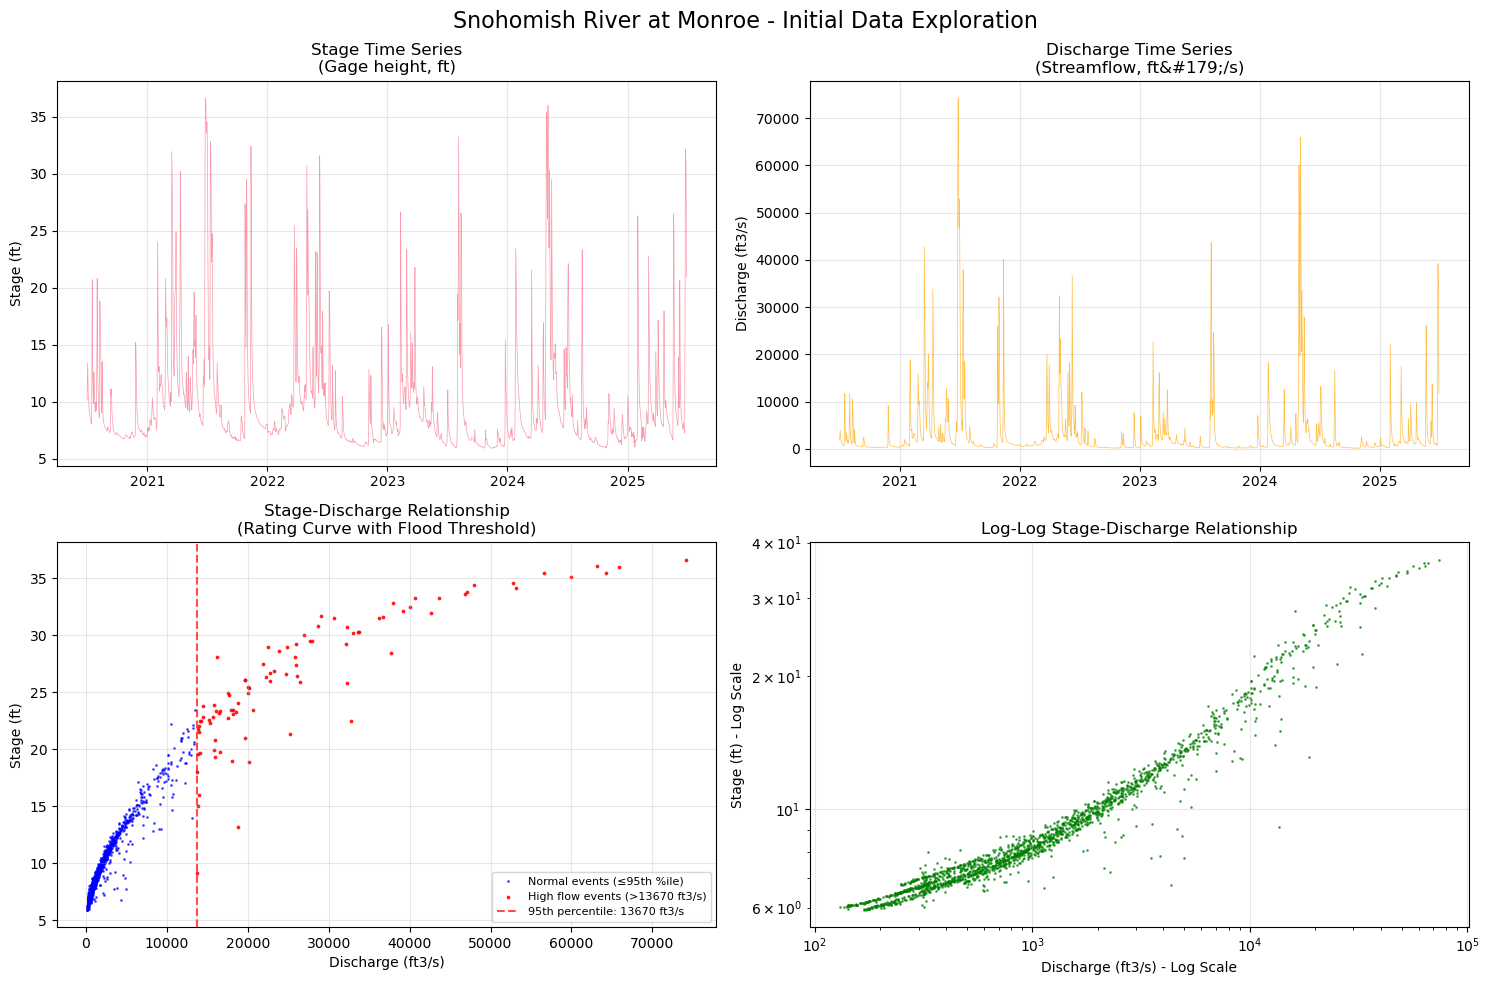

,qualifiers_stage,value_stage,qualifiers_discharge,value_discharge
dateTime,,,,
2020-07-01,10.14,[A],1810,[A]
2020-07-02,11.57,[A],2990,[A]
2020-07-03,13.41,[A],4040,[A]
2020-07-04,11.55,[A],2560,[A]
2020-07-05,10.30,[A],1800,[A]
...,...,...,...,...
2025-06-25,21.30,[P],25200,[P]
2025-06-26,32.15,[P],39200,[P]
2025-06-27,31.54,[P],36200,[P]


In [7]:
# Combine datasets and create visualizations
# part of data exploration and visualization

if stage_data is not None and discharge_data is not None: # error handling
    print(f"\nData Summary:")
    print(f"Stage data: {len(stage_data)} records")
    print(f"Discharge data: {len(discharge_data)} records")

    # combine datasets
    combined_data = pd.merge(stage_data, discharge_data, left_index=True, right_index=True, 
                           suffixes=('_stage', '_discharge'))
    combined_data.columns = ['qualifiers_stage', 'value_stage', 'qualifiers_discharge', 'value_discharge']

    print(f"Combined dataset: {len(combined_data)} records with both stage and discharge")

    total_days = len(combined_data)
    years_of_data = total_days / 365.25

    # Calculate 95th percentile for high flow analysis
    discharge_95th = combined_data['qualifiers_discharge'].quantile(0.95)
    high_flow_events = combined_data[combined_data['qualifiers_discharge'] > discharge_95th]
    

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Snohomish River at Monroe - Initial Data Exploration', fontsize=16)

    # Time series plots
    axes[0, 0].plot(combined_data.index, combined_data['qualifiers_stage'], alpha=0.7, linewidth=0.5)
    axes[0, 0].set_title(f'Stage Time Series\n({stage_name})')
    axes[0, 0].set_ylabel(f'Stage ({stage_unit})')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(combined_data.index, combined_data['qualifiers_discharge'], alpha=0.7, linewidth=0.5, color='orange')
    axes[0, 1].set_title(f'Discharge Time Series\n({discharge_name})')
    axes[0, 1].set_ylabel(f'Discharge ({discharge_unit})')
    axes[0, 1].grid(True, alpha=0.3)

    # Stage-discharge relationship (the key relationship!)
    normal_events = combined_data[combined_data['qualifiers_discharge'] <= discharge_95th]


    axes[1, 0].scatter(normal_events['qualifiers_discharge'], normal_events['qualifiers_stage'], 
                      alpha=0.6, s=1, color='blue', label='Normal events (≤95th %ile)')
    
    # Plot high flow events in red
    axes[1, 0].scatter(high_flow_events['qualifiers_discharge'], high_flow_events['qualifiers_stage'], 
                      alpha=0.8, s=3, color='red', label=f'High flow events (>{discharge_95th:.0f} {discharge_unit})')
    
    # Add vertical line at 95th percentile
    axes[1, 0].axvline(x=discharge_95th, color='red', linestyle='--', alpha=0.7, 
                      label=f'95th percentile: {discharge_95th:.0f} {discharge_unit}')
    axes[1, 0].set_xlabel(f'Discharge ({discharge_unit})')
    axes[1, 0].set_ylabel(f'Stage ({stage_unit})')
    axes[1, 0].set_title('Stage-Discharge Relationship\n(Rating Curve with Flood Threshold)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(fontsize=8)



    # Log-log relationship (often more linear)
    valid_data = combined_data[(combined_data['qualifiers_discharge'] > 0) & (combined_data['qualifiers_stage'] > 0)]
    axes[1, 1].scatter(valid_data['qualifiers_discharge'], valid_data['qualifiers_stage'], 
                        alpha=0.6, s=1, color='green')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_xlabel(f'Discharge ({discharge_unit}) - Log Scale')
    axes[1, 1].set_ylabel(f'Stage ({stage_unit}) - Log Scale')
    axes[1, 1].set_title('Log-Log Stage-Discharge Relationship')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve both stage and discharge data. Check the site ID and date range.")

combined_data

## Scraping NOAA/NWS flood level data

In [54]:
from bs4 import BeautifulSoup

def scrape_nws_flood_levels(site_code):
    """
    Scrape flood warning levels from NOAA/NWS website
    
    params:
        site_code: NWS site code (e.g., 'MROW1' for Monroe)
    
    output:
        Dictionary with flood level information
    """

    url = f"https://water.noaa.gov/gauges/{site_code}"
    
    print(f"Scraping flood levels from: {url}")
    
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # look for flood level information
        # Note: This is a simplified scraper generated by Claude - the actual website structure may vary
        flood_levels = {}
        
        # try to find flood level tables or sections
        # this will need to be adjusted based on the actual website structure
        print("Website content retrieved successfully")
        print("Note: Flood level extraction needs manual inspection of website structure")
        
        # save the HTML for inspection
        with open('/home/disk/rocinante/vickyye/data/raw/nws_monroe_page.html', 'w', encoding='utf-8') as f:
            f.write(response.text)
        
        print("HTML content saved to /home/disk/rocinante/vickyye/data/raw/nws_monroe_page.html for inspection")
        
        return {"status": "HTML saved", "url": url}
        
    except requests.exceptions.RequestException as e:
        print(f"Error scraping NWS data: {e}")
        return None

# scrape NWS flood warning data for Monroe
nws_site_code = 'MROW1'  # Monroe, WA
nws_data = scrape_nws_flood_levels(nws_site_code)

print("\n" + "="*60)
print("INITIAL FINDINGS AND NEXT STEPS")
print("="*60)

if 'combined_data' in locals():
    # Calculate some basic flood-related statistics
    stage_percentiles = combined_data['qualifiers_stage'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    discharge_percentiles = combined_data['qualifiers_discharge'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
    
    print(f"\nStage Percentiles ({stage_unit}):")
    for percentile, value in stage_percentiles.items():
        print(f"  {percentile*100:2.0f}th percentile: {value:.2f}")
    
    print(f"\nDischarge Percentiles ({discharge_unit}):")
    for percentile, value in discharge_percentiles.items():
        print(f"  {percentile*100:2.0f}th percentile: {value:.0f}")
    
    # Identify potential high-flow events (>95th percentile)
    high_flow_events = combined_data[combined_data['qualifiers_discharge'] > discharge_percentiles[0.95]]
    print(f"\nHigh flow events (>95th percentile): {len(high_flow_events)}")
    print(f"That's approximately {len(high_flow_events)/len(combined_data)*365:.1f} events per year")

print(f"\nNext Steps:")
print("1. Manually inspect the NWS website HTML to find flood warning level structure")
print("2. Develop proper flood level extraction from NWS data")
print("3. Compare stage percentiles with official flood warning thresholds")
print("4. Fit mathematical models to the stage-discharge relationship")
print("5. Validate the rating curve against USGS official rating tables")

print(f"\nKey Questions to Address:")
print("- What are the official flood warning levels (Action, Minor, Moderate, Major) in feet?")
print("- How well does a power law model fit the stage-discharge relationship?")
print("- Are there seasonal patterns in the stage-discharge relationship?")
print("- How stable is this relationship over time?")


Scraping flood levels from: https://water.noaa.gov/gauges/MROW1
Website content retrieved successfully
Note: Flood level extraction needs manual inspection of website structure
HTML content saved to /home/disk/rocinante/vickyye/data/raw/nws_monroe_page.html for inspection

INITIAL FINDINGS AND NEXT STEPS

Stage Percentiles (ft):
  50th percentile: 3.17
  75th percentile: 4.45
  90th percentile: 6.01
  95th percentile: 7.29
  99th percentile: 11.30

Discharge Percentiles (ft3/s):
  50th percentile: 7240
  75th percentile: 11200
  90th percentile: 16900
  95th percentile: 22500
  99th percentile: 39946

High flow events (>95th percentile): 89
That's approximately 17.9 events per year

Next Steps:
1. Manually inspect the NWS website HTML to find flood warning level structure
2. Develop proper flood level extraction from NWS data
3. Compare stage percentiles with official flood warning thresholds
4. Fit mathematical models to the stage-discharge relationship
5. Validate the rating curve ag